# Timeseries Prediction

** EVERYTHING IN THIS TUTORIAL IS VERY NEW AND EXPERIMENTAL! CONSIDER IT ON AN ALPHA PHASE!**

**APIs WILL BE CHANGING LIKE 99.99% GUARANTEED**

Topics:

* Nature of prediction models of **DynamicalSystems.jl**
* Local Model prediction
* Prediction of scalar timeseries
* Multi-variate Prediction!
* Docstrings

## Nature of prediction models
Suppose you have a scalar or multi-variate timeseries and you want to predict its future behaviour.

You can either take your *neural-network/machine-learning hammer* and lots of computing power **or** you can use methods from nonlinear dynamics and chaos.

**DynamicalSystems.jl** follows the second approach. This road is not only surprisingly powerful, but also much, **much** cheaper.

---

# Local Model Prediction

Local model prediction does something very simple: it makes prediction a of a state, by finding the future of similar (*neighboring*) states! Then it uses the predicted state as a new state to make a prediction for.

Yeap, that simple.

Let's see how well this method fares in a simple system, the Roessler system (3D & chaotic):

$$
\begin{aligned}
\dot{x} &= -y-z \\
\dot{y} &= x+ay \\
\dot{z} &= b + z(x-c)
\end{aligned}
$$

In [1]:
using DynamicalSystems 

# This i.c. gives good prediction:
u0_good = [0.065081, 0.917503, 0.300242]

ross = Systems.roessler(u0_good)

3-dimensional continuous dynamical system
 state:     [0.065081, 0.917503, 0.300242]
 e.o.m.:    DynamicalSystemsBase.Systems.roessler_eom
 in-place?  false
 jacobian:  DynamicalSystemsBase.Systems.roessler_jacob


In [2]:
# Let's get a "measurement" from the roessler system
dt = 0.1 # sampling rate
tf = 1000.0 # final time
tr = trajectory(ross, tf; dt = dt)

# This is the measurement
s = tr[50:end, 2] # we skip the first points, they are transient
# This is the accompanying time vector:
timevec = collect(0:dt:tf)[50:end];

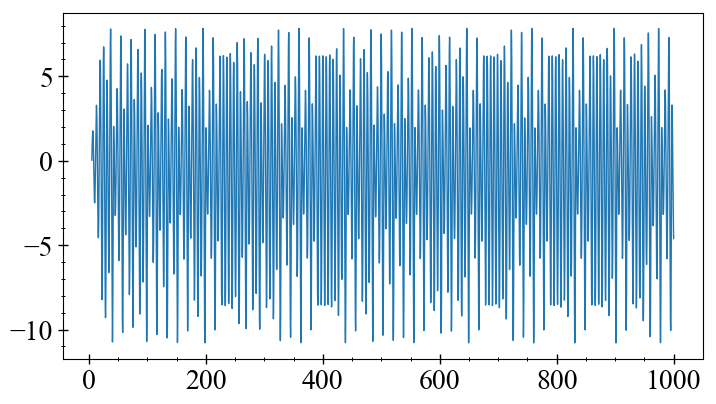

In [3]:
# How does this timeseries look?
using PyPlot; figure(figsize = (8,4))
plot(timevec, s, lw = 1.0);

Please note: these are chaotic oscillations, the system is *not* periodic for the chosen (default) parameter values!

Alright, so we have a recorded some timeseries of length:

In [4]:
length(s)

9952

And now we want to predict!

Let's see the prediction function in action! The function to use is
```julia
localmodel_tsp(s, D::Int, τ, p::Int; kwargs...)
```
Here `s` is the timeseries to be predicted. `D, τ` are the values of the `Reconstruction` that has to be made from `s`. The last argument `p` is simply the amount of points to predict!

The `Reconstruction` idea and functions were introduced in the tutorial "Delay Coordinates Embedding". 

This local model prediction method assumes that the system is on some kind of chaotic attractor. This is why it is crucial to reconstruct a signal before using the method!

In [5]:
N = length(s)

# Use only a first part of the timeseries as a "training set"
N_train = 1000
s_train = s[1:N_train]

# use the rest of the timeseries to compare with the prediction
s_test = s[N_train+1:end]

# parameters to predict:
τ = 17
D = 3
p = 500

s_pred = localmodel_tsp(s_train, D, τ, p) # prediction always includes last point of `s_train`

501-element Array{Float64,1}:
 -1.01244 
 -0.618513
 -0.25985 
  0.107845
  0.481012
  0.855973
  1.22897 
  1.59618 
  1.95381 
  2.29806 
  2.62522 
  2.93168 
  3.21399 
  ⋮       
  6.92972 
  7.25001 
  7.49616 
  7.66678 
  7.76051 
  7.77608 
  7.71248 
  7.56916 
  7.34617 
  7.04425 
  6.66491 
  6.21044 

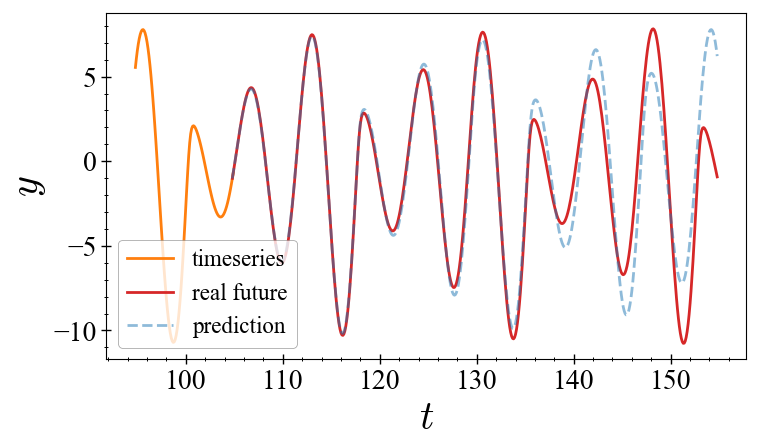

Prediction of 500 points from 1000 points. i.c.: [0.065081, 0.917503, 0.300242]


In [6]:
# Let's plot
figure(figsize=(8,4))
past = 100
plot(timevec[N_train-past:N_train+1], s[N_train-past:N_train+1], color = "C1", label = "timeseries")
plot(timevec[N_train:N_train+p], s[N_train:N_train+p], color = "C3", label = "real future")
plot(timevec[N_train:N_train+p], s_pred, color = "C0", linestyle = "dashed", alpha = 0.5, label = "prediction")
legend(); xlabel("\$t\$"); ylabel("\$y\$")
println("Prediction of $(p) points from $(N_train) points. i.c.: $(state(ross))")

Of course the prediction depends strongly on:

* Choosing proper `Reconstruction` parameters
* The initial condition

How did I know that the value of `τ=17` was good?

In [7]:
estimate_delay(s, "first_zero")

17

The function `localmodel_tsp` also accepts some keyword arguments which I did not discuss. These are:

  * `method = AverageLocalModel(2)` : Subtype of [`AbstractLocalModel`](@ref).
  * `ntype = FixedMassNeighborhood(2)` : Subtype of [`AbstractNeighborhood`](@ref).
  * `stepsize = 1` : Prediction step size.
  
So, we already know from the tutorial on "Datasets" what does the `ntype` keyword does: it chooses a neighborhood type.

The `method` keyword chooses the method of the local prediction. There are two methods, the `AverageLocalModel`, which we already used by default, as well as the `LinearLocalModel`. Their docstrings are at the end of this tutorial.

Without explanations, their call signatures are:
```julia
AverageLocalModel(n::Int)
LinearLocalModel(n::Int, μ::Real)
LinearLocalModel(n::Int, s_min::Real, s_max::Real)
```

In [8]:
# Let's bundle all of this process in one function, and play around!
# But first, let's benchmark!
using BenchmarkTools
@btime localmodel_tsp($s_train, $D, $τ, $p)
println("Time for predicting $(p) points from $(N_train) points.")

  593.242 μs (6029 allocations: 455.09 KiB)
Time for predicting 500 points from 1000 points.


N_train = 3000, p = 500, method = LinearLocalModel, u0 = [0.258031, 0.726889, 0.0731835]

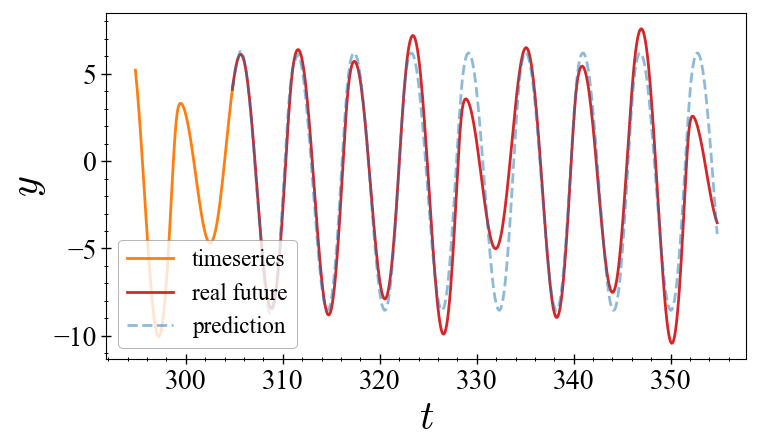

In [9]:
function predict_roessler(N_train, p, method, u0 = rand(3); ntype = FixedMassNeighborhood(5))
    
    ds = Systems.roessler(u0)
    dt = 0.1
    tr = trajectory(ds, (N_train+p)÷dt; dt = dt)
    
    s = tr[:, 2] # actually, any of the 3 variables of the Roessler work well
    
    s_train = s[1:N_train]
    s_test = s[N_train+1:end]

    # parameters to predict:
    τ = 17
    D = 3

    s_pred = localmodel_tsp(s_train, D, τ, p; method = method, ntype = ntype)
    
    figure(figsize=(8,4))
    past = 100
    plot(timevec[N_train-past:N_train+1], s[N_train-past:N_train+1], color = "C1", label = "timeseries")
    plot(timevec[N_train:N_train+p], s[N_train:N_train+p], color = "C3", label = "real future")
    plot(timevec[N_train:N_train+p], s_pred, color = "C0", linestyle = "dashed", alpha = 0.5, label = "prediction")
    legend(); xlabel("\$t\$"); ylabel("\$y\$")   
    mprint = Base.datatype_name(typeof(method))
    println("N_train = $(N_train), p = $(p), method = $(mprint), u0 = $(u0)")
    return
end

predict_roessler(3000, 500, LinearLocalModel(2, 5.0))
# Linear Local model is slower than Average local model, and in general not that
# much more powerful.

# Multi-Variate Prediction

*I was being sneaky so far*. 

On purpose I was always referring to `s` as "timeseries". There is no reason for `s` to be scalar though, this prediction method works just as well when predicting multiple timeseries. And the call signature does not change at all!

The following example demonstrates the prediction of the Lorenz96 model, a system that displays high-dimensional chaos and is thus very difficult to predict!

Delay estimation: 9


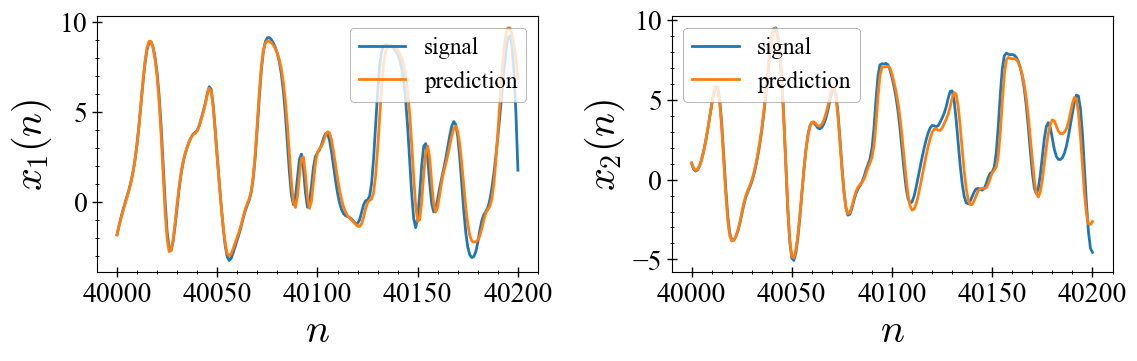

Prediction p=200 of Lorenz96 Model (5 Nodes) from 40000 points
i.c.: [0.231723, 0.262068, 0.922903, 0.748131, 0.419049]


In [14]:
using DynamicalSystemsBase, PyPlot

#Generate timeseries set
ds = Systems.lorenz96(5; F=8.)
ic = state(ds)
Δt = 0.05
s = trajectory(ds, 2100; dt=Δt)[:,1:2]

#Set Training and Test Set
N_train = 40000
p = 200
s_train = s[1:N_train,1:2]
s_test  = s[N_train:N_train+p,1:2]

#Embedding Parameters
D = 5; # total dimension of reconstruction is D*2 ! ! !
x = s[:, 1]
τ = estimate_delay(x, "first_zero")
println("Delay estimation: $(τ)")

#Prediction
method = LinearLocalModel(2, 2.5)
method = AverageLocalModel(2)
ntype = FixedMassNeighborhood(5)
s_pred  = localmodel_tsp(s_train, D, τ, p; method = method, ntype = ntype)


figure(figsize=(12,4))
ax = subplot(121)
plot(N_train:N_train+p, s_test[:,1], label="signal")
plot(N_train:N_train+p, s_pred[:,1], label="prediction")
ylabel("\$x_1(n)\$")
xlabel("\$n\$")
legend()
ax = subplot(122)
plot(N_train:N_train+p, s_test[:,2], label="signal")
plot(N_train:N_train+p, s_pred[:,2], label="prediction")
ylabel("\$x_2(n)\$")
xlabel("\$n\$")
legend()
tight_layout();
println("Prediction p=$p of Lorenz96 Model (5 Nodes) from $N_train points")
println("i.c.: $ic")

# Docstrings

In [11]:
?localmodel_tsp

search: localmodel_tsp AverageLocalModel AbstractLocalModel LinearLocalModel



```
localmodel_tsp(s, D::Int, τ, p::Int; method, ntype, stepsize)
localmodel_tsp(s, p::Int; method, ntype, stepsize)
```

Perform a timeseries prediction for `p` points, using local weighted modeling [1]. The function always returns an object of the same type as `s`, which can be either a timeseries (vector) or an `AbstractDataset` (trajectory), and the returned data always contains the final point of `s` as starting point. This means that the returned data has length of `p + 1`.

If given `(s, D, τ)`, then a [`Reconstruction`](@ref) is performed on `s` with dimension `D` and delay `τ`. If given only `s` then no [`Reconstruction`](@ref) is done. Keep in mind that the intented behavior of the algorithm is to work with a reconstruction, and not "raw" data.

## Keyword Arguments

  * `method = AverageLocalModel(2)` : Subtype of [`AbstractLocalModel`](@ref).
  * `ntype = FixedMassNeighborhood(2)` : Subtype of [`AbstractNeighborhood`](@ref).
  * `stepsize = 1` : Prediction step size.

## Description

Given a query point, the function finds its neighbors using neighborhood `ntype`. Then, the neighbors `xnn` and their images `ynn` are used to make a prediction for the future of the query point, using the provided `method`. The images `ynn` are the points `xnn` shifted by `stepsize` into the future.

The algorithm is applied iteratively until a prediction of length `p` has been created, starting with the query point to be the last point of the timeseries.

## References

[1] : Eds. B. Schelter *et al.*, *Handbook of Time Series Analysis*, VCH-Wiley, pp 39-65 (2006)


In [12]:
?AbstractLocalModel

search: AbstractLocalModel



```
AbstractLocalModel
```

Supertype of methods for making a prediction of a query point `q` using local models, following the methods of [1]. Concrete subtypes are `AverageLocalModel` and `LinearLocalModel`.

All models weight neighbors with the following weight function

$$
\begin{aligned}
ω_i = \left[ 1- \left(\frac{d_i}{d_{max}}\right)^n\right]^n
\end{aligned}
$$

with $d_i = ||x_{nn,i} -q||_2$ and degree `n`, to ensure smoothness of interpolation.

### Average Local Model

```
AverageLocalModel(n::Int)
```

The prediction is simply the weighted average of the images $y_{nn, i}$ of the neighbors $x_{nn, i}$ of the query point `q`:

$$
\begin{aligned}
y_{pred} = \frac{\sum{ω_i^2 y_{nn,i}}}{\sum{ω_i^2}}
\end{aligned}
$$

### Linear Local Model

```
LinearLocalModel(n::Int, μ::Real)
LinearLocalModel(n::Int, s_min::Real, s_max::Real)
```

The prediction is a weighted linear regression over the neighbors $x_{nn, i}$ of the query and their images $y_{nn,i}$ as shown in [1].

Giving either `μ` or `s_min` and `s_max` determines which type of regularization is applied.

  * `μ` : Ridge Regression

    $$
    \begin{aligned}
    f(σ) = \frac{σ^2}{μ^2 + σ^2}
    \end{aligned}
    $$
  * `s_min`, `s_max` : Soft Threshold

    $$
    \begin{aligned}
    f(σ) = \begin{cases} 0, &σ < s_{min}\\
    \left(1 - \left( \frac{s_{max}-σ}{s_{max}-s_{min}}\right)^2 \right)^2, &s_{min} \leq
    σ \leq s_{max} \\
    1, &σ > s_{max}\end{cases}
    \end{aligned}
    $$

## References

[1] : Eds. B. Schelter *et al.*, *Handbook of Time Series Analysis*, VCH-Wiley, pp 39-65 (2006)
